# Simulation of samples

This tutorial demonstrates how to create simple simulations using geometrical volume masks and sources.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import colorcet
from mumott import Simulator
from mumott.methods.basis_sets import GaussianKernels
from mumott import Geometry
from mumott.core.geometry import GeometryTuple
from mumott.methods.projectors import SAXSProjectorCUDA
from mumott.output_handling import ProjectionViewer
from mumott.core.projection_stack import ProjectionStack
from mumott.core.projection_stack import Projection
from mumott import DataContainer
from mumott.pipelines import run_mitra

INFO:Setting the number of threads to 4. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


## Defining the volume

We begin by defining a mask for the volume wher we wish to create the simulation.

In [2]:
size = 50
left_value = size / 2 - 0.5
right_value = size / 2 + 0.5
volume_mask = np.zeros((size,) * 3)
x, y, z = np.mgrid[-left_value:right_value, -left_value:right_value, -left_value:right_value]
r = np.sqrt(x ** 2 + y ** 2 + z ** 2) * 2 / size
volume_mask[r < 0.75] = 1
volume_mask[24:26, :, 9:] = 0
volume_mask[35:37, :, 15:] = 0
volume_mask[30:32, :, 7:38] = 0

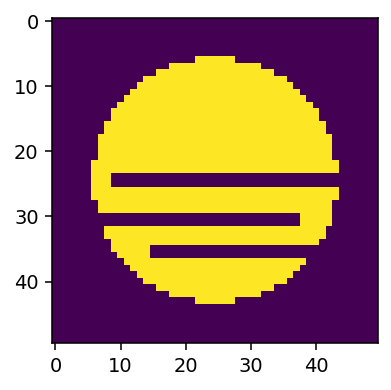

In [3]:
f, ax = plt.subplots(1, figsize=(3, 4), dpi=140)
ax.imshow(volume_mask[:, 25, :])

## Defining the simulation and sources

We define a simple basis set, a ``GaussianKernels`` with ``grid_scale=2``, where the small number of coefficients makes it more likely that randomly generated tensors will have a clear orientation, and initialize the simulator. You can change the parameters of the sources and see how it affects their influence and the resulting simulation.

In [4]:
basis_set = GaussianKernels(grid_scale=2)
simulator = Simulator(volume_mask, basis_set=basis_set, seed=1534)

In [5]:
simulator.add_source(location=(15, 35, 35), influence_exponent=1, influence_scale_parameter=12)
simulator.add_source(location=(20, 22, 15), influence_exponent=1.5, influence_scale_parameter=10)
simulator.add_source(location=(40, 28, 25), influence_exponent=0.5, influence_scale_parameter=8)
simulator.add_source(location=(33, 16, 36), influence_exponent=2, influence_scale_parameter=12)
sources = simulator.sources
influences = sources['influences']

We illustrate the sources, which shows that the ``Simulator`` uses the interior distances to determine the influence of each source. The influences always sum to unity.

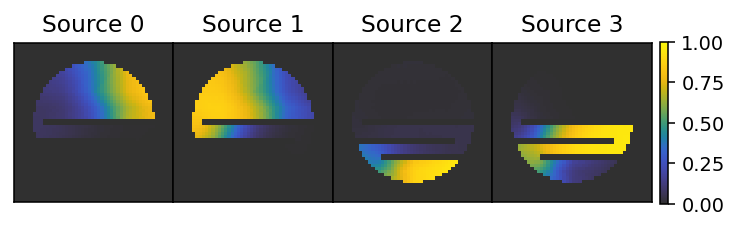

In [6]:
f, ax = plt.subplots(1, 4, figsize=(7, 1.5), dpi=140)
plot_kwargs = dict(cmap='cet_gouldian', vmin=0, vmax=1)
plt.subplots_adjust(hspace=0, wspace=0)

for i, a in enumerate(ax):
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(f'Source {i}')
    im = a.imshow(influences[i][:, 25, :], **plot_kwargs)
plt.colorbar(im, ax=ax, pad=0.01)

## Carrying out the simulation

We execute the simulation. There are many parameters that can be tuned, to e.g. modify the norms that the iterative reweighting scheme converges towards, or changing the thresholds for what the optimization considers a small value. One can also make the step size smaller or change the weight and execute the optimization again.

You can choose whether or not to run `simulator.reset_simulation()` between each optimization attempt. When called, this method will set all simulation coefficients to `0`.

In [7]:
# simulator.reset_simulation()
simulator.optimize(iterations=25, weighting_iterations=25, tv_weight=0.15, step_size=0.01, power_weight=0.1, residual_delta=1e-2, tv_delta=1e-2, power_delta=1e-3)

Loss: 2.73e+03 Resid: 1.22e+03 TV: 8.33e+03 Pow: 2.61e+03: 100%|██████████| 25/25 [02:47<00:00,  6.71s/it]


To analyze the results we here define a convenience function that allows us to extract mean, fractional anisotropy, and orientation data in a 2D slice from the reconstruction.

The function defined here uses ``output.eigenvector_1`` which corresponds to the direction with lowest scattering, For equatorial ring type scattering ``output.eigenvector_1`` is apropriate. For polar cap type scattering, ``output.eigenvector_3``.

In [8]:
plotted_slice_index = 25
mask_threshold = 0.03

def get_2d_images(output):

    mean = output.mean_intensity[:, plotted_slice_index]
    mask = mean > mask_threshold

    fractional_anisotropy = output.fractional_anisotropy[:, plotted_slice_index]
    fractional_anisotropy[~mask] = 1

    main_eigenvector = output.eigenvector_1[:, plotted_slice_index]
    orientation = np.arctan2(-main_eigenvector[..., 2],
                             main_eigenvector[..., 0])
    orientation[orientation < 0] += np.pi
    orientation[orientation > np.pi] -= np.pi
    orientation *= 180 / np.pi

    alpha = np.clip(output.fractional_anisotropy[:, plotted_slice_index], 0, 1)
    alpha[~mask] = 0

    return mean, fractional_anisotropy, orientation, alpha


In [9]:
sim_mean, sim_fractional_anisotropy, sim_orientation, sim_alpha = get_2d_images(basis_set.get_output(simulator.simulation))

/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/methods/basis_sets/gaussian_kernels.py:490: RuntimeWarning: invalid value encountered in divide
  fractional_anisotropy = fractional_anisotropy / np.sqrt(2*np.sum(eigenvalues**2, axis=-1))


In [10]:
colorbar_kwargs = dict(orientation='horizontal', shrink=0.75, pad=0.1)
mean_kwargs = dict(vmin=0, vmax=0.2, cmap='cet_gouldian')
fractional_anisotropy_kwargs = dict(vmin=0, vmax=1.0, cmap='cet_fire')
orientation_kwargs = dict(vmin=0, vmax=180, cmap='cet_CET_C6')

def config_cbar(cbar):
    cbar.set_ticks([i for i in np.linspace(0, 180, 5)])
    cbar.set_ticklabels([r'$' + f'{int(v):d}' + r'^{\circ}$' for v in bar.get_ticks()])

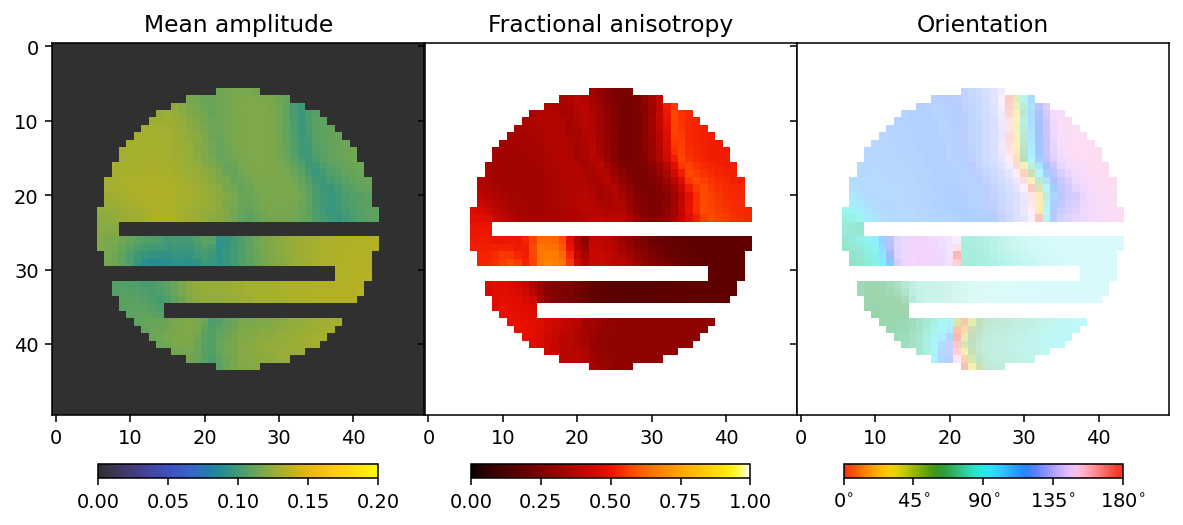

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10.3, 4.6), dpi=140, sharey=True)

im0 = ax[0].imshow(sim_mean, **mean_kwargs);
im1 = ax[1].imshow(sim_fractional_anisotropy, **fractional_anisotropy_kwargs);
im2 = ax[2].imshow(sim_orientation, alpha=sim_alpha, **orientation_kwargs);

ax[0].set_title('Mean amplitude')
ax[1].set_title('Fractional anisotropy')
ax[2].set_title('Orientation')

plt.subplots_adjust(wspace=0)

plt.colorbar(im0, ax=ax[0], **colorbar_kwargs)
plt.colorbar(im1, ax=ax[1], **colorbar_kwargs)
bar = plt.colorbar(im2, ax=ax[2], **colorbar_kwargs)
config_cbar(bar)

## Creating artificial data

We then define the geometry for the projection simulation, including the rotations and tilts (inner and outer axis-angle pairs). For convenience we save the geometry configuration.

We use a simple spiral scheme, 16 rotations around the main axis with a tilt up to 90 degrees, to see what a near-ideal reconstruction might look like.

In [12]:
geometry = Geometry()

number_of_projections = 200

for i in range(number_of_projections):
    geometry.append(GeometryTuple())

geometry.inner_angles = np.linspace(0, 32 * np.pi, number_of_projections)
geometry.outer_angles = np.linspace(0, 0.5 * np.pi, number_of_projections)
geometry.p_direction_0 = np.array([0, 0, 1])
geometry.j_direction_0 = np.array([0, 1, 0])
geometry.k_direction_0 = np.array([1, 0, 0])
geometry.inner_axes = np.array([0, 1, 0])
geometry.outer_axes = np.array([1, 0, 0])

geometry.volume_shape = simulator.shape
geometry.detector_angles = np.arange(0, np.pi, np.pi / 8)
geometry.projection_shape = np.array((50, 50))
geometry.write('simulation_geometry.geo')

INFO:None values found in some axis or angle entries, rotations not updated.
INFO:None values found in some axis or angle entries, rotations not updated.
INFO:None values found in some axis or angle entries, rotations not updated.


We then carry out the mapping into detector-image space.

In [13]:
projector = SAXSProjectorCUDA(geometry)
basis_set = GaussianKernels(grid_scale=2, probed_coordinates=geometry.probed_coordinates)
forward_projections = basis_set.forward(projector.forward(simulator.simulation.astype(np.float32)))

Then we create a Data container and we append projections to it, and read the previously written geometry.

In [14]:
dc = DataContainer()
for i, f in enumerate(forward_projections):
    frame = Projection(data=f, diode=np.ones_like(f[..., 0]), weights=np.ones_like(f))
    dc.projections.append(frame)
dc.geometry.read('simulation_geometry.geo')

## Reconstructing the artifical data

We then carry out a reconstruction to compare to the simulation.

In [15]:
results = run_mitra(dc,
                    use_gpu=True,
                    maxiter=50,
                    basis_set_kwargs=dict(grid_scale=2),
                    use_absorbances=False)

reconstruction = results['result']['x']
output = results['basis_set'].get_output(reconstruction)

100%|██████████| 50/50 [00:06<00:00,  7.65it/s]


/das/home/carlse_m/p20850/envs/mumott_latest/lib/python3.11/site-packages/mumott/methods/basis_sets/gaussian_kernels.py:490: RuntimeWarning: invalid value encountered in divide
  fractional_anisotropy = fractional_anisotropy / np.sqrt(2*np.sum(eigenvalues**2, axis=-1))


Finally we compare the reconstruction to the simulation.

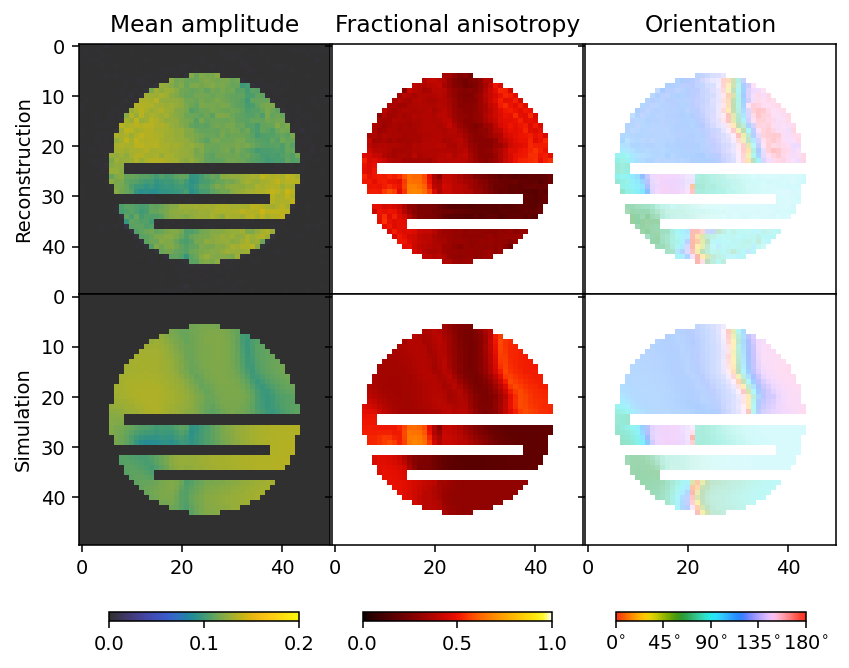

In [16]:
mean, fractional_anisotropy, orientation, alpha = get_2d_images(output)
fig, ax = plt.subplots(2, 3, figsize=(7, 6.2), dpi=140, sharey=True, sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

im0 = ax[0, 0].imshow(mean, **mean_kwargs);
im1 = ax[0, 1].imshow(fractional_anisotropy, **fractional_anisotropy_kwargs);
im2 = ax[0, 2].imshow(orientation, alpha=alpha, **orientation_kwargs);
ax[0, 0].set_ylabel('Reconstruction')

im0 = ax[1, 0].imshow(sim_mean, **mean_kwargs);
im1 = ax[1, 1].imshow(sim_fractional_anisotropy, **fractional_anisotropy_kwargs);
im2 = ax[1, 2].imshow(sim_orientation, alpha=sim_alpha, **orientation_kwargs);
ax[1, 0].set_ylabel('Simulation')

ax[0, 0].set_title('Mean amplitude')
ax[0, 1].set_title('Fractional anisotropy')
ax[0, 2].set_title('Orientation')

plt.subplots_adjust(wspace=0)

plt.colorbar(im0, ax=ax[:, 0], **colorbar_kwargs)
plt.colorbar(im1, ax=ax[:, 1], **colorbar_kwargs)
bar = plt.colorbar(im2, ax=ax[:, 2], **colorbar_kwargs)
config_cbar(bar)